In [1]:
import numpy as np 
import pandas as pd 
import warnings
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')
df=pd.read_csv('../input/nyse/prices.csv')
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [2]:
df["symbol"].unique()

array(['WLTW', 'A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABT', 'ACN', 'ADBE',
       'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AET',
       'AFL', 'AGN', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL',
       'ALXN', 'AMAT', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN',
       'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB',
       'AVGO', 'AVY', 'AWK', 'AXP', 'AYI', 'AZO', 'BA', 'BAC', 'BAX',
       'BBBY', 'BBT', 'BBY', 'BCR', 'BDX', 'BEN', 'BHI', 'BIIB', 'BK',
       'BLK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CA', 'CAG', 'CAH',
       'CAT', 'CB', 'CBG', 'CBS', 'CCI', 'CCL', 'CELG', 'CERN', 'CF',
       'CHD', 'CHK', 'CHRW', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA',
       'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COH',
       'COL', 'COO', 'COP', 'COST', 'CPB', 'CRM', 'CSCO', 'CSX', 'CTAS',
       'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE',
       'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 

In [3]:
data = df[df['symbol']=='AAPL'].reset_index()['close']
data.head()

0    214.009998
1    214.379993
2    210.969995
3    210.580000
4    211.980005
Name: close, dtype: float64

Text(0, 0.5, 'Prices ($)')

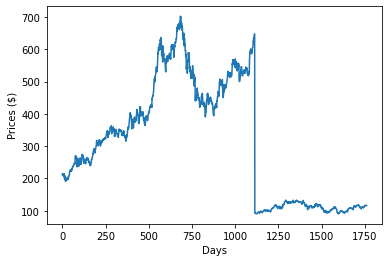

In [4]:
import matplotlib.pyplot as plt
plt.plot(data)
plt.xlabel('Days')
plt.ylabel('Prices ($)')

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(np.array(data).reshape(-1,1))
training_data=data[0:int(len(data)*0.65),:]
test_data=data[int(len(data)*0.65):int(len(data)*0.85),:]
val_data=data[int(len(data)*0.85):,:]
training_data.shape,test_data.shape,val_data.shape

((1145, 1), (352, 1), (265, 1))

In [6]:
def create_dataset(dataset, time_step=1):
	X, Y = [], []
	for i in range(len(dataset)-time_step-1):
		x = dataset[i:(i+time_step), 0]   
		X.append(x)
		Y.append(dataset[i + time_step, 0])
	return np.array(X), np.array(Y)
time_step = 100
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_train.shape

(1044, 100)

In [7]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [9]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(125,return_sequences=True))
model.add(LSTM(75))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()],optimizer='adam')

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 125)          88000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 75)                60300     
_________________________________________________________________
dense (Dense)                (None, 25)                1900      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 160,626
Trainable params: 160,626
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
17/17 [==============================] - 16s 485ms/step - loss: 0.0543 - root_mean_squared_error: 0.2329 - val_loss: 0.0269 - val_root_mean_squared_error: 0.1641
Epoch 2/10
17/17 [==============================] - 7s 386ms/step - loss: 0.0109 - root_mean_squared_error: 0.1043 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1223
Epoch 3/10
17/17 [==============================] - 7s 385ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0610
Epoch 4/10
17/17 [==============================] - 7s 411ms/step - loss: 0.0064 - root_mean_squared_error: 0.0797 - val_loss: 5.8071e-04 - val_root_mean_squared_error: 0.0241
Epoch 5/10
17/17 [==============================] - 7s 427ms/step - loss: 0.0058 - root_mean_squared_error: 0.0765 - val_loss: 6.0171e-04 - val_root_mean_squared_error: 0.0245
Epoch 6/10
17/17 [==============================] - 7s 403ms/step - loss: 0.0059 - root_mean_squared_error: 0.0770 - val_loss: 0.00

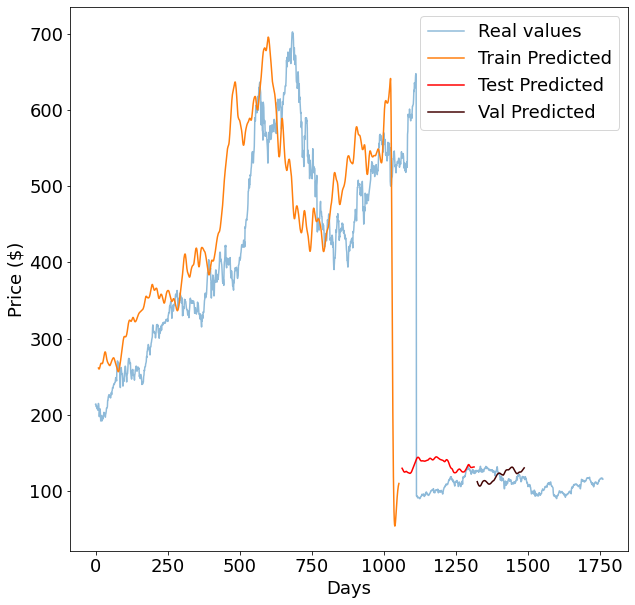

In [12]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
val_predict=model.predict(X_val)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
val_predict=scaler.inverse_transform(val_predict)
data_from=data_to=0
look_back=10
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
data_from=look_back
data_to=len(train_predict)+look_back
trainPredictPlot[data_from:data_to, :] = train_predict

testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
data_from=data_to+10
data_to=data_from+len(test_predict)
testPredictPlot[data_from:data_to, :] = test_predict

valPredictPlot = np.empty_like(data)
valPredictPlot[:, :] = np.nan
data_from=data_to+10
data_to=data_from+len(val_predict)
valPredictPlot[data_from:data_to, :] = val_predict

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,10))
plt.plot(scaler.inverse_transform(data),label='Real values',alpha=0.5)
plt.plot(trainPredictPlot,label='Train Predicted')
plt.plot(testPredictPlot,label='Test Predicted',color='#FF0000')
plt.plot(valPredictPlot,label='Val Predicted',color='#420303')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

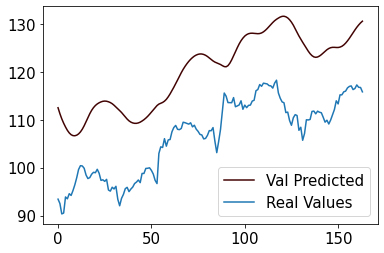

In [13]:
plt.rcParams.update({'font.size': 15})
plt.plot(val_predict,color='#420303',label='Val Predicted')
plt.plot(scaler.inverse_transform(data[-164:]),label='Real Values')
plt.legend()
plt.show()